In [7]:
# Use-case 1: Stock Market Price Prediction for Tesla Stock

# Begin by importing all necessary imports where we have decided to use a polynomial regression model to predict
# the stock price of Tesla as stock prices seldomly fluctuate linearly. 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [8]:
# First, we need to read in the csv data that we downloaded from the Tesla Yahoo pages.
url = "/Users/gisle/Documents/ARIMA-MODELLING/Tesla-Stock-Modelling/TSLA.csv"
# Create a data frame out of the raw data that we downloaded from Yahoo
df = pd.read_csv(url)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
1,2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900
2,2022-10-26,219.399994,230.600006,218.199997,224.639999,224.639999,85012500
3,2022-10-27,229.770004,233.809998,222.850006,225.089996,225.089996,61638800
4,2022-10-28,225.399994,228.860001,216.350006,228.520004,228.520004,69152400
...,...,...,...,...,...,...,...
245,2023-10-16,250.050003,255.399994,248.479996,253.919998,253.919998,88917200
246,2023-10-17,250.100006,257.179993,247.080002,254.850006,254.850006,93562900
247,2023-10-18,252.699997,254.630005,242.080002,242.679993,242.679993,125147800
248,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700


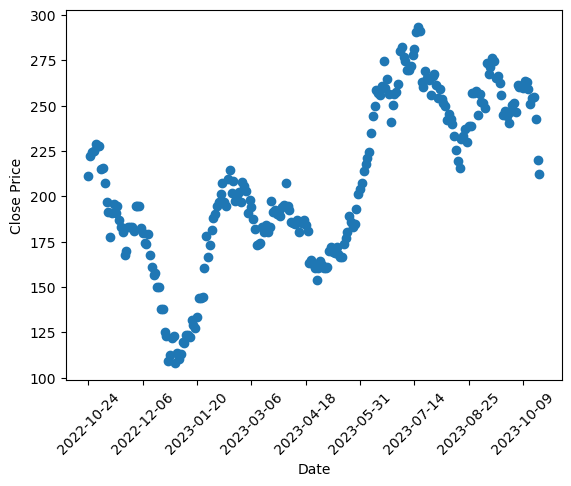

In [9]:
# Now we want to create a scatterplot where input is the date and the output is the closing price of the Tesla Stock
plt.scatter(x='Date', y='Close', data=df)
plt.xticks(df['Date'][::30], rotation=45)  # Label every 30th date, and rotate labels by 45 degrees for readability
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [17]:
# Now that we have visualized the stock price of this graph so far, let's apply the ARIMA model to the dataset.

# First we need to apply a stationary check to ensure that the time series are stationary

# Check for stationarity by performing the Dickey-Fuller test and we typically do this using the close price as the dependent variable
result = adfuller(df['Close'])
print('Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Calculate the critical values
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


Test Statistic: -1.718939
p-value: 0.421382
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [20]:
""" The test is not negative enough to strongly reject the null hypothesis of a unit root, i.e the significance of this is not enough to 
    rule out a unit root!
      
    The p value of 0.42 is very high, much higher than 0.01 or 0.05 so that there's not enough evidence to reject the null hypothesis of the presence
    of a unit root, so there's a fair chance that the series is non-stationary. Then we must transform the series to make it stationary! """

# Through trial and error, let's start off with differencing the data set
df['Close_diff'] = df['Close'].diff()
df = df.dropna()  # Drop rows with NaN values because otherwise we'd get errors with missing values

result1 = adfuller(df['Close_diff'])
print('Test Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

Test Statistic: -5.935242
p-value: 0.000000


In [22]:
""" More promising results with the test statistic, but the 0 p value is very suspicious. 
    We'll add the log transformation to double check our calculations. """

# .loc acessor to state that we want to modify the original data frame
# Apply log transformation to the original 'Close' series
df.loc[:, 'Close_log'] = np.log(df['Close'])
# Calculate the first difference of the log-transformed series
df.loc[:, 'Close_log_diff'] = df['Close_log'].diff().dropna()

# Perform the ADF test on the first difference of the log-transformed series
result_log_diff = adfuller(df['Close_log_diff'].dropna())
print('Test Statistic: %f' % result_log_diff[0])
print('p-value: %f' % result_log_diff[1])

Test Statistic: -5.935242
p-value: 0.000000


In [13]:
"""

# The code below calculates the R squared score, which is a measurement of the variance of the predicted data compared to the real data.
# In other words, we are simply observing how well the predicted plot compares to the actual plot. 0 is the lowest which means that there is a very
# poor fit, whilst 1 represents a perfect fit. In the print method below, we simply multiply it by 100 to get our predicted "percentage" score.
r2_score = model.score(X_poly_test, y_test)
print(f"R-squared (prediction percentage) score: {r2_score * 100:.2f}%") """


'\n\n# The code below calculates the R squared score, which is a measurement of the variance of the predicted data compared to the real data.\n# In other words, we are simply observing how well the predicted plot compares to the actual plot. 0 is the lowest which means that there is a very\n# poor fit, whilst 1 represents a perfect fit. In the print method below, we simply multiply it by 100 to get our predicted "percentage" score.\nr2_score = model.score(X_poly_test, y_test)\nprint(f"R-squared (prediction percentage) score: {r2_score * 100:.2f}%") '

In [14]:
!conda info


     active environment : dave3625
    active env location : C:\Users\gisle\miniconda3\envs\dave3625
            shell level : 1
       user config file : C:\Users\gisle\.condarc
 populated config files : C:\Users\gisle\.condarc
          conda version : 23.7.4
    conda-build version : not installed
         python version : 3.11.4.final.0
       virtual packages : __archspec=1=x86_64
                          __win=0=0
       base environment : C:\Users\gisle\miniconda3  (writable)
      conda av data dir : C:\Users\gisle\miniconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
       